## **Case study: Predict stent deployed configuration in real time**

In this class, we will build a data-driven, static reduced order model (ROM) of stent deployment capable of predicting in **real time** the stent deployed configuration given a certain vessel geometry.

### **What are stents?**
Stents are small, tube-like devices used to hold open narrowed or blocked arteries or other blood vessels in the body. They are often made of metal or plastic mesh and are commonly used in procedures like angioplasty to restore blood flow in cases of coronary artery disease. Some stents are coated with medication to prevent the artery from narrowing again, while others are simple mechanical supports.

There exist two main types of stents. Balloon-expandable stents are made from materials like stainless steel and are deployed by inflating a balloon inside the stent, which forces it to expand. They provide high radial force and are ideal for precise placement, such as in coronary arteries. In contrast, self-expandable stents are made from shape-memory materials like nitinol. They expand on their own after being released from a catheter and are more flexible, making them suitable for areas that experience movement or compression, like peripheral arteries.

In this class, we will focus on the self-expandable stents.

![Balloon-expandable stent](https://i.imgur.com/dWsdVgo.jpeg)
![Self-expandable stent](https://i.imgur.com/3d7OVob.jpeg)

### **Why we need a ROM of stents?**
Examples of why a ROM for stent deployment is needed:
*  **Optimization Study:** A ROM enables running multiple simulations with varying geometrical or material properties of the stent to find the combination that maximizes specific performance metrics, such as radial force, flexibility, and fatigue resistance.
*   **Planning Software:** By using a ROM, clinicians can compare different treatment options before actual deployment, evaluating various devices, sizes, and deployment sites to choose the most suitable option for each patient.
*   **Intraoperative Support:** ROM can help visualize the deployed configuration overlaid on fluoroscopy images in real-time during the intervention, assisting surgeons with precise positioning and adjustments.

### **What is the focus of this class?**
In this class, we will focus on building a ROM of the deployed configuration of a stent given a set of parameters describing the vessel geometry. In the first part of the class, we will work on an idealised vessel geometry. Our parameters will represent the curvature and radius of this vessel as long as the clinical decision on where to position the stent.

![Parametric vessel](https://i.imgur.com/Em7mFE5.png)

In the second part of the class, we will investigate how this model can be translated to a realistic case with patient-specific geeometries.

![Patient-specific vessel](https://i.imgur.com/cdbmj58.png)

### How is the class structured?
1. Mathematical definition of the problem
2. Sampling
3. Building the database
4. Building and testing the ROM

![Schema](https://i.imgur.com/cjbySFE.png)







## **Mathematical definition of the problem**

Insert image to explain the parametric model.



## **Setting up the environment**


In [29]:
# Pull the repo with data and install packages for the notebook if we're in Google Colab
import os
try:
  import google.colab # Check if we're in Google Colab
  !sudo apt install libgl1-mesa-glx xvfb
  !pip install pyvista[jupyter] -qq
  current_directory = os.path.basename(os.getcwd())
  # If we're not in the right directory or the directory doesn't exist, clone the repo
  if not (os.path.isdir('NotebookROM') or current_directory == 'NotebookROM'):
    !git clone https://github.com/bisighinibeatrice/NotebookROM.git
  if os.path.isdir('NotebookROM'):
    %cd NotebookROM
except:
    pass



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import shutil
shutil.rmtree('NotebookROM')


FileNotFoundError: [Errno 2] No such file or directory: 'NotebookROM'

In [ ]:
from importlib import reload
import utils
utils = reload(utils) # Reload the module in case it has changed
import numpy as np
from ipywidgets import interactive

In [ ]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

## **Sampling**

In reduced order modelling, the sampling step is crucial for generating a representative set of data points that capture the variability of the system.The Latin Hypercube Sampling (LHS) technique is commonly used for this purpose. LHS is a statistical method that divides the parameter space into equally probable intervals and ensures that samples are distributed uniformly across the entire space. This technique reduces the risk of clustering and improves the efficiency of sampling compared to simple random sampling, making it ideal for high-dimensional problems. It helps in covering the parameter space more thoroughly with fewer samples, which enhances the accuracy of the ROM while minimizing computational costs.

**EXERCISE:** This is a Python example of the use of LHS for sampling two parameters (`num_dimensions`). Plot the distribution of the points for different number of samples (`num_samples`).

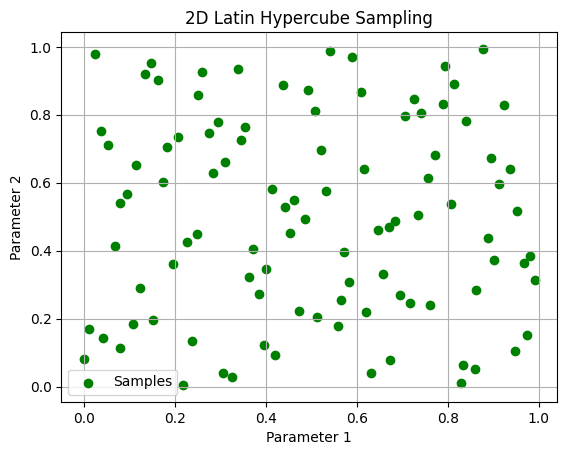

In [ ]:
# Define number of parameters
num_dimensions = 2

# Define sample size
num_samples = 100

# Create a Latin Hypercube Sampler
lhs_sampler = qmc.LatinHypercube(d=num_dimensions)
lhs_sample = lhs_sampler.random(n=num_samples)

# Plot the results
plt.scatter(lhs_sample[:, 0], lhs_sample[:, 1], c='green', label='Samples')
plt.title('2D Latin Hypercube Sampling')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.grid(True)
plt.legend()
plt.show()

The LHS provides values between 0 and 1. How can we change the ranges in which the parameters are varying? We need to rescale the data.

To scale the data from the unit interval [0,1] to a specified range [a,b], we can use this equation:

$x_{\text{scaled}} = a + (b - a) \cdot x_{\text{sample}}$

where $x_{\text{scaled}}$ is the scaled value, $x_{\text{sample}}$ is the original LHS sample in the range [0,1], $a$ is the lower bound of the target range, and $b$ is the upper bound of the target range.

**EXERCISE:** Implement this equation to rescale the data and plot the scaled results.

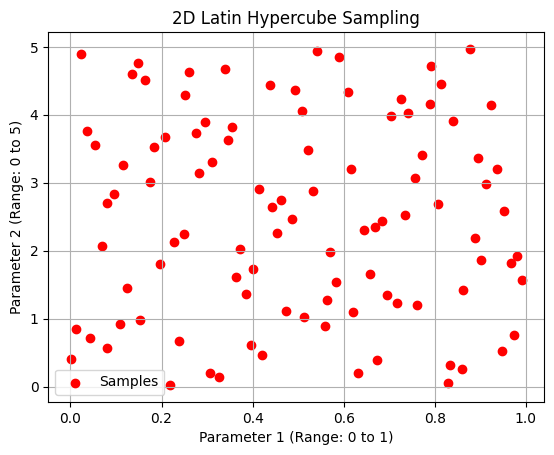

In [ ]:
# Parameters bounds
param1_bounds = (0.0, 1.0)  # Range for Parameter 1
param2_bounds = (0.0, 5.0)  # Range for Parameter 2

# Updated bounds for the two parameters
bounds = [param1_bounds, param2_bounds]

# Scale the LHS sample to the given bounds
scaled_lhs_sample = np.empty_like(lhs_sample)
for i, (lower, upper) in enumerate(bounds):
    scaled_lhs_sample[:, i] = lower + lhs_sample[:, i] * (upper - lower)

# Plot the results
plt.scatter(scaled_lhs_sample[:, 0], scaled_lhs_sample[:, 1], c='red', label='Samples')
plt.title('2D Latin Hypercube Sampling')
plt.xlabel('Parameter 1 (Range: 0 to 1)')
plt.ylabel('Parameter 2 (Range: 0 to 5)')
plt.grid(True)
plt.legend()
plt.show()

Let's go back to our original problem of interest. We have 4 parameters (vessel radius, control point x and y coordinates, and deploy site), which are varying in these ranges:
*   `vessel_radius_bounds = (1.0, 2.5)`
*   `control_point_x_bounds = (0.0, 50.0)`
*   `control_point_y_bounds = (0.0, 50.0)`
*   `deploy_site_bounds = (0.01, 1.0)`

**EXERCISE:**  Change the LHS code to compute `num_samples = 100` with LHS (considering the ranges indicated above) and save it in a text file.

In [ ]:
# Parameters
num_dimensions = 4
vessel_radius_bounds = (1.0, 2.5)  # Range for vessel radius
control_point_x_bounds = (0.0, 50.0)  # Control point X bounds
control_point_y_bounds = (0.0, 50.0)  # Control point Y bounds
deploy_site_bounds = (0.01, 1.0)  # Range for deploy_site (0 to 1)

# Updated bounds to include deploy_site
bounds = [vessel_radius_bounds, control_point_x_bounds, control_point_y_bounds, deploy_site_bounds]

# Define sample size
num_samples = 100

# Create a Latin Hypercube Sampler
lhs_sampler = qmc.LatinHypercube(d=num_dimensions)
lhs_sample = lhs_sampler.random(n=num_samples)

# Scale the LHS sample to the given bounds
scaled_lhs_sample = np.empty_like(lhs_sample)
for i, (lower, upper) in enumerate(bounds):
  scaled_lhs_sample[:, i] = lower + lhs_sample[:, i] * (upper - lower)

# Output the train subsets and the test subset
np.savetxt(f"parameters_{num_samples}.txt", scaled_lhs_sample, fmt="%.2f")

## **Building the database: 1) Creating the geometries**

Considering


In [ ]:
# Function to read vessel radius and control points from a file (for multiple models)
def read_input_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse each line into a dictionary of parameters for each model
    model_params = []
    for line in lines:
        values = line.split()  # Assuming space-separated or comma-separated values
        vessel_radius = float(values[0])
        # The control point can have positions on both X and Z, Y is kept at 0
        control_point = np.array([float(values[1]), 0.0, float(values[2])])
        model_params.append((vessel_radius, control_point))

    return model_params

# Function to calculate the binomial coefficient nCk using a recursive approach
def binomial_coefficient(n, k):
    if k == 0:
        return 1
    else:
        return round(n/k * binomial_coefficient(n-1, k-1))

In [ ]:
def compute_model(index):

  # Input file containing model parameters (one set per line)
  num_full_sample = 100
  input_file = f"parameters_{num_full_sample}.txt"

  # Read the input data for all models
  all_model_params = read_input_from_file(input_file)


  # Process each model and generate the corresponding files
  vessel_radius = all_model_params[index][0]
  control_point = all_model_params[index][1]

  # Define the common X position and different Z positions for start and end points
  common_x = 0
  start_z = 0
  end_z = 50

  # Define the control points for the spline (3 control points in 3D)
  start_point = np.array([common_x, 0, start_z])  # Starting point (X, Y, Z)
  end_point = np.array([common_x, 0, end_z])  # End point at the same X but different Z

  # -------------------------------------------------------------------------
  # Create Bernstein polynomial for spline interpolation

  control_points = np.array([start_point, control_point, end_point])  # Array of control points
  degree = len(control_points)  # Degree of the Bernstein polynomial (2 in this case)
  num_divisions = 10  # Number of divisions for interpolating points along the curve
  bernstein_points = []  # Object to store Bernstein-interpolated points

  # Loop through each value of u (parameter between 0 and 1) to compute the spline points
  for u in np.arange(0, 1 + (1 / num_divisions), 1 / num_divisions):
      point_sum = np.array([0.0, 0.0, 0.0])  # Sum of control point contributions
      for i in np.arange(1, degree + 1):
          # Compute Bernstein basis polynomial B_i^n(u)
          bernstein_value = binomial_coefficient(degree, i - 1) * (u ** (i - 1)) * ((1 - u) ** (degree - i + 1))
          point_sum += bernstein_value * control_points[i - 1]  # Sum the control point contributions
      bernstein_value = binomial_coefficient(degree, degree) * (u ** degree)
      point_sum += bernstein_value * control_points[degree - 1]
      bernstein_points.append(point_sum)

  # Converti i punti in un array NumPy
  bernstein_points = np.array(bernstein_points)

  # Plot dei punti su un grafico
  plt.figure()
  plt.plot(bernstein_points[:, 2], bernstein_points[:, 0], 'bo-', label='Spline curve')
  plt.scatter(control_points[:, 2], control_points[:, 0], color='red', marker='*', s=100,  label='Control Points', zorder=2)
  plt.xlabel('Axis Z')
  plt.ylabel('Axis X')
  plt.title('Spline interpolation using Bernstein polynomials')
  plt.legend()
  plt.grid(True)
  plt.show()

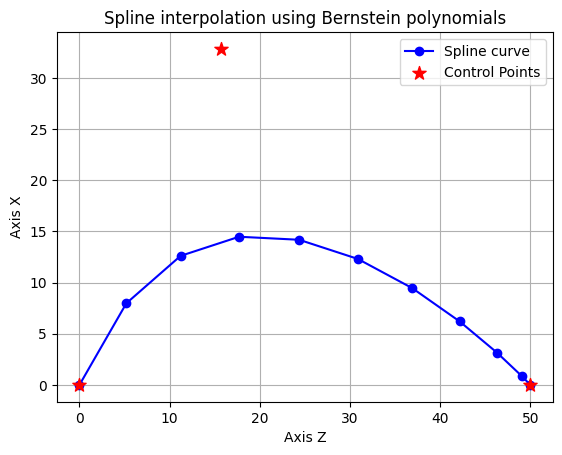

In [ ]:
index = 1
compute_model(index)

## **Building the database: 1) Running the simulations**


## **Building the ROM**


Explain: Reduced order modelling and machine learning model.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load parameters and simulations from text files
def load_data(parameters_file, simulations_file):
    parameters = np.loadtxt(parameters_file)
    simulations = np.loadtxt(simulations_file)
    return parameters, simulations

Initially, we will use the data in its raw form as input for the machine learning model.

In [ ]:
# Example usage
N = 100
parameters_file = f"Input/parameters_{N}.txt"  # Replace with your actual file name
simulations_file = f"Input/simulations_{N}.txt"  # Replace with your actual file name

# Step 1: Load the data
parameters, simulations = load_data(parameters_file, simulations_file)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(parameters, simulations, test_size=0.25, random_state=42)

In [ ]:
# Step 4: Build the Kriging model on the data
# Define a kernel for the Gaussian Process
initial_kernel = C(1.0, (1e1, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-2)

# Create the GaussianProcessRegressor with the defined kernel
gp = GaussianProcessRegressor(kernel=initial_kernel, n_restarts_optimizer=10, random_state=42)

# Fit the Gaussian Process model to the reduced data
gp.fit(X_train, y_train)

# Step 5: Predict using the Kriging model on the test data
y_pred = gp.predict(X_test)

As we observe, the machine learning model struggles to converge and establish a mapping between the input and output when using the raw data. This could be due to the large variation between the input and output data. To evaluate this, we can compute statistical measures like the variance or standard deviation for both the input and output datasets. These metrics will help us quantify the spread or dispersion in the data, providing insight into whether significant differences in scale or range between the input and output are affecting the model's ability to learn.

In [ ]:
# Calculate variation (standard deviation and variance) for input and output
input_variance = np.var(parameters, axis=0)
input_std_dev = np.std(parameters, axis=0)

output_variance = np.var(simulations, axis=0)
output_std_dev = np.std(simulations, axis=0)

print(input_variance)
print(input_std_dev)
print(output_variance)
print(output_std_dev)

[1.87588000e-01 2.08357769e+02 2.07941477e+02 8.15341900e-02]
[ 0.4331143  14.43460318 14.42017602  0.28554192]
[31.4126335   0.06573417 59.45063162 ... 37.60445521  0.14158189
 59.14194723]
[5.60469745 0.25638676 7.71042357 ... 6.13224716 0.37627369 7.69038017]


To improve performance, we can **standardize** the data, which involves transforming the features to have a mean of zero and a standard deviation of one.

In [ ]:
# Standardize both training and test sets for the output
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Standardize both training and test sets for the input
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

Let's visualise the change in variance.

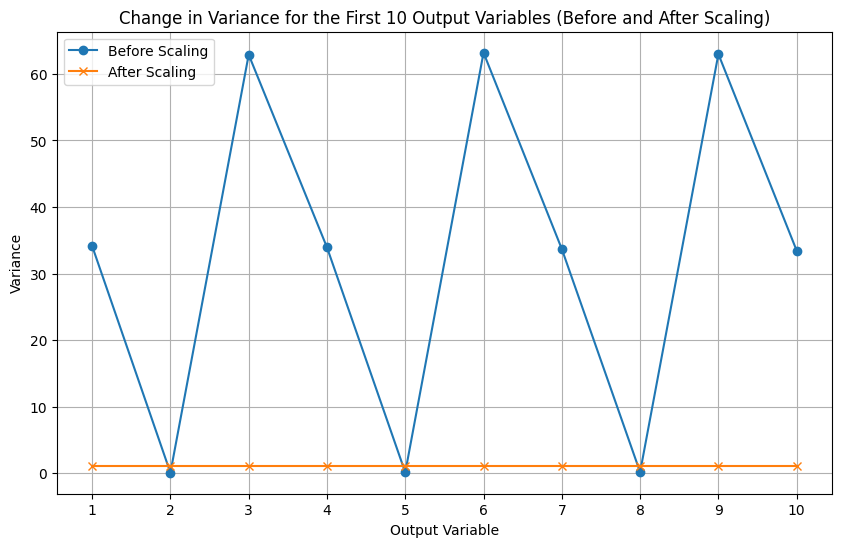

In [ ]:
# Compute variances for the first 10 output variables before scaling
variances_before = np.var(y_train[:, :10], axis=0)

# Compute variances for the first 10 output variables after scaling
variances_after = np.var(y_train_scaled[:, :10], axis=0)

# Plot the variances before and after scaling
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), variances_before, label='Before Scaling', marker='o')
plt.plot(range(1, 11), variances_after, label='After Scaling', marker='x')
plt.title('Change in Variance for the First 10 Output Variables (Before and After Scaling)')
plt.xlabel('Output Variable')
plt.ylabel('Variance')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

Let's retrain the machine learning model.

In [ ]:

# Step 4: Build the Kriging model on the data
# Define a kernel for the Gaussian Process
initial_kernel = C(1.0, (1e2, 1e3)) * RBF(1.0, (1e-2, 1e1)) + WhiteKernel(noise_level=1e-2)

# Create the GaussianProcessRegressor with the defined kernel
gp = GaussianProcessRegressor(kernel=initial_kernel, n_restarts_optimizer=10, random_state=42)

# Fit the Gaussian Process model to the reduced data
gp.fit(X_train_scaled, y_train_scaled)

# Step 5: Predict using the Kriging model on the test data
y_pred_scaled = gp.predict(X_test_scaled)

# Inverse transform to reconstruct the original output
y_pred = scaler_y.inverse_transform(y_pred_scaled)

The code still struggles to converge, which may be due to the complexity of learning all of these outputs simultaneously. How many output is our system composed of?

In [ ]:
print(y_train.shape)

(75, 2952)


We need to **compress** this output, and one effective approach is to utilize Principal Component Analysis (PCA). This technique reduces the dimensionality of the data by transforming it into a set of uncorrelated variables, known as principal components, which capture the most significant variance in the output while minimizing information loss.

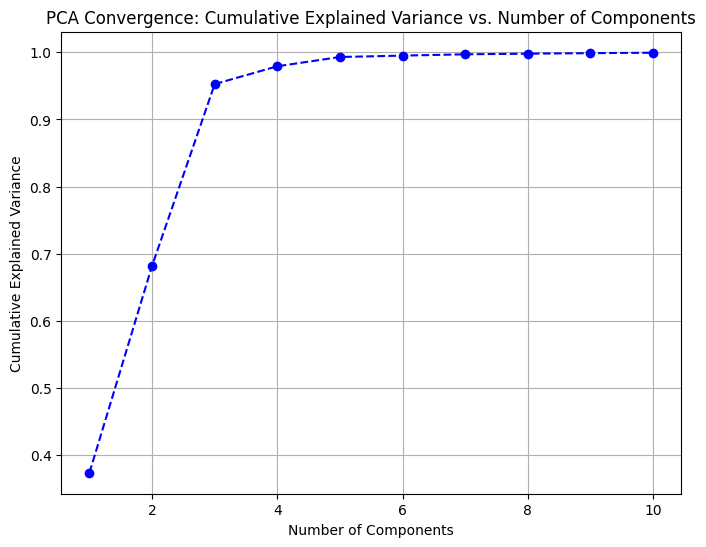

In [ ]:
#  Step 3: Create the PCA on the output (simulations)
n_components = 10
pca_simulations = PCA(n_components=n_components)

# Fit and transform the output
y_train_scaled_reduced = pca_simulations.fit_transform(y_train_scaled)

# Plot the cumulative explained variance
explained_variance = np.cumsum(pca_simulations.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Convergence: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# Create the GaussianProcessRegressor with the defined kernel
gp = GaussianProcessRegressor(kernel=initial_kernel, n_restarts_optimizer=10, random_state=42)

# Fit the Gaussian Process model to the reduced data
gp.fit(X_train_scaled, y_train_scaled_reduced)

# Step 5: Predict using the Kriging model on the test data
y_pred_scaled_reduced = gp.predict(X_test_scaled)

# Inverse transform to reconstruct the original output
y_pred_scaled = pca_simulations.inverse_transform(y_pred_scaled_reduced)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


The model has been successfully trained, and now we need to **evaluate** its performance. For a regression model, we can assess its performance using metrics such as:
*   Mean squared error (MSE);
*   Mean absolute error (MAE).
MSE measures the average squared difference between predicted and actual values, providing insight into the model's accuracy, while MAE gives a straightforward average of absolute errors, making it easier to interpret.

In [ ]:
# Calculate MAE for each case
mae_vec = []
rmse_vec = []
for i in range(y_test.shape[0]):
    mae = mean_absolute_error(y_test[i, :], y_pred[i, :])
    rmse = np.sqrt(mean_squared_error(y_test[i, :], y_pred[i, :]))
    mae_vec.append(mae)
    rmse_vec.append(rmse)

print(f" MAE: {np.mean(mae_vec)}")
print(f" RMSE: {np.mean(rmse_vec)}")


 MAE: 0.34657377811128787
 RMSE: 0.4969973919503151


We can now compare the performance of the reduced order model when we use a larger training database.

In [ ]:
for N in [100,250,500,1000]:

    print(N)

    # Example usage
    parameters_file = f"Input/parameters_{N}.txt"  # Replace with your actual file name
    simulations_file = f"Input/simulations_{N}.txt"  # Replace with your actual file name

    # Step 1: Load the data
    parameters, simulations = load_data(parameters_file, simulations_file)

    # Step 2: Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(parameters, simulations, test_size=0.25, random_state=42)

    # Standardize both training and test sets for the output
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Standardize both training and test sets for the input
    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    # Step 3: Create the PCA on the output (simulations)
    n_components = 10
    pca_simulations = PCA(n_components=n_components)

    # Fit and transform the output
    y_train_scaled_reduced = pca_simulations.fit_transform(y_train_scaled)

    # Step 4: Build the Kriging model on the data
    # Define a kernel for the Gaussian Process
    initial_kernel = C(1.0, (1e2, 1e3)) * RBF(1.0, (1e-2, 1e1)) + WhiteKernel(noise_level=1e-2)

    # Create the GaussianProcessRegressor with the defined kernel
    gp = GaussianProcessRegressor(kernel=initial_kernel, n_restarts_optimizer=10, random_state=42)

    # Fit the Gaussian Process model to the reduced data
    gp.fit(X_train_scaled, y_train_scaled_reduced)

    # Step 5: Predict using the Kriging model on the test data
    y_pred_scaled_reduced = gp.predict(X_test_scaled)

    # Inverse transform to reconstruct the original output
    y_pred_scaled = pca_simulations.inverse_transform(y_pred_scaled_reduced)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Calculate MAE for each case
    mae_vec = []
    rmse_vec = []
    for i in range(y_test.shape[0]):
        mae = mean_absolute_error(y_test[i, :], y_pred[i, :])
        rmse = np.sqrt(mean_squared_error(y_test[i, :], y_pred[i, :]))
        mae_vec.append(mae)
        rmse_vec.append(rmse)

    print(f" MAE: {np.mean(mae_vec)}")
    print(f" RMSE: {np.mean(rmse_vec)}")


100


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 MAE: 0.3465737781377337
 RMSE: 0.49699739199354037
250


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 MAE: 0.2170679414615781
 RMSE: 0.3085820442353571
500


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 MAE: 0.09218161540755879
 RMSE: 0.13425515172267175
1000
 MAE: 0.09115265055162146
 RMSE: 0.13254733399417074
